In [211]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
import requests
import os
import seaborn as sns
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

Check dataset and correlations

<bound method NDFrame.head of        agricultural sciences  engineering and technology  humanities  \
0                        0.0                         0.0         0.0   
1                        0.0                         0.0         2.0   
2                        1.0                         0.0         0.0   
3                        0.0                         0.0         0.0   
4                        0.0                         0.0         0.0   
...                      ...                         ...         ...   
15334                    0.0                         4.0         0.0   
15335                    0.0                         1.0         0.0   
15336                    0.0                         0.0         0.0   
15337                    0.0                         1.0         0.0   
15338                    0.0                         0.0         0.0   

       medical and health sciences  natural sciences  social sciences  \
0                              0

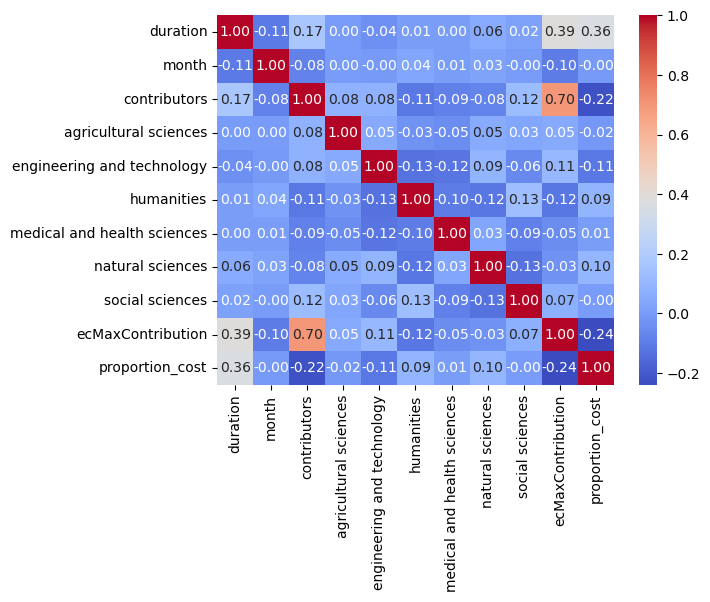

In [214]:
os.chdir("C:\\Users\\32493\\Google Drive\\ku leuven\\data analysis\\MDA\\CSV FILES")
os.getcwd()
df = pd.read_csv("Dataset_for_model.csv")
print(df.head)
print(df.info())
# Check correlation with target
numeric_cols = num_features + ['ecMaxContribution'] + ['proportion_cost']
sns.heatmap(train[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Set all the scientific fields to dichotomous values (0 or 1)

Distribution of ECmaxcontribution + proportion_cost

min     4.659400e+04
max     5.494420e+08
mean    2.854007e+06
Name: ecMaxContribution, dtype: float64


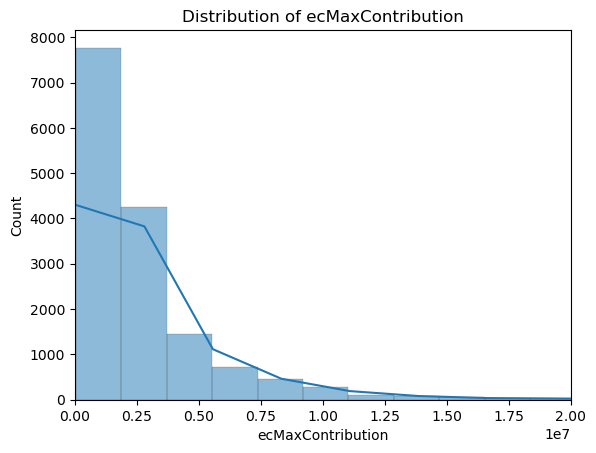

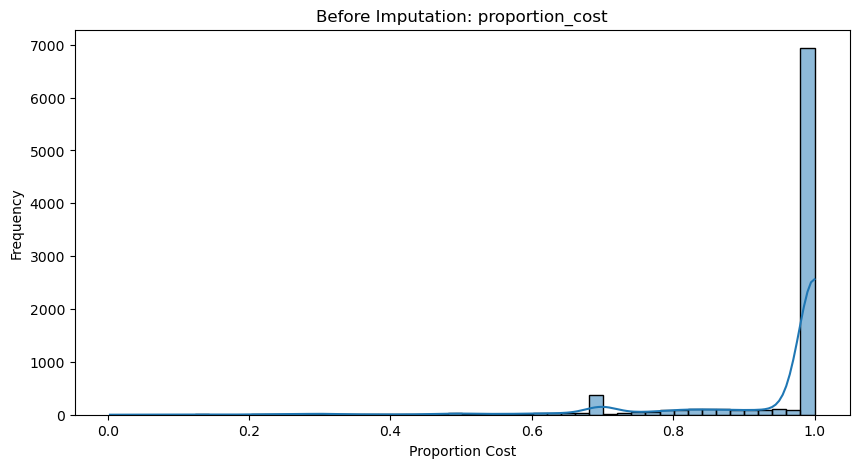

In [218]:
sns.histplot(df['ecMaxContribution'], bins=300, kde=True)
plt.title('Distribution of ecMaxContribution')
plt.xlim(0, 20000000)
print(df['ecMaxContribution'].describe()[['min', 'max', 'mean']])

# Plot original data with missing values
plt.figure(figsize=(10, 5))
sns.histplot(df['proportion_cost'], bins=50, kde=True)
plt.title("Before Imputation: proportion_cost")
plt.xlabel("Proportion Cost")
plt.ylabel("Frequency")
plt.show()


In [219]:
df['engineering and technology'] = (df['engineering and technology'] > 0).astype(int)
df['agricultural sciences'] = (df['agricultural sciences'] > 0).astype(int)
df['humanities'] = (df['humanities'] > 0).astype(int)
df['medical and health sciences'] = (df['medical and health sciences'] > 0).astype(int)
df['natural sciences'] = (df['natural sciences'] > 0).astype(int)
df['social sciences'] = (df['social sciences'] > 0).astype(int)
print(df.head(n=10))

   agricultural sciences  engineering and technology  humanities  \
0                      0                           0           0   
1                      0                           0           1   
2                      1                           0           0   
3                      0                           0           0   
4                      0                           0           0   
5                      0                           1           0   
6                      0                           1           0   
7                      0                           0           0   
8                      0                           1           0   
9                      0                           0           0   

   medical and health sciences  natural sciences  social sciences  \
0                            0                 1                0   
1                            1                 1                0   
2                            0              

10 equal bins based on quantiles

Check upper and lower values of each bin

In [224]:
q05_df = df['ecMaxContribution'].quantile(0.01)
q95_df = df['ecMaxContribution'].quantile(0.99)
df['ecMaxContribution'] = df['ecMaxContribution'].clip(lower=q05_df, upper=q95_df)

# Define bins (adjust as needed)
df['ecMaxClass'] = pd.qcut(df['ecMaxContribution'], q=10, labels=False, duplicates='drop')

binned_series, bin_edges = pd.qcut(df['ecMaxContribution'], q=10, retbins=True, duplicates='drop')
print("Bin edges:", bin_edges)

Bin edges: [   75000.           166278.72         191760.           253532.16
  1494410.6         1808750.          2339975.          2630937.4
  3991157.01        6096397.9        17831684.43499988]


In [226]:
print(df.head)
print(df.info())

<bound method NDFrame.head of        agricultural sciences  engineering and technology  humanities  \
0                          0                           0           0   
1                          0                           0           1   
2                          1                           0           0   
3                          0                           0           0   
4                          0                           0           0   
...                      ...                         ...         ...   
15334                      0                           1           0   
15335                      0                           1           0   
15336                      0                           0           0   
15337                      0                           1           0   
15338                      0                           0           0   

       medical and health sciences  natural sciences  social sciences  \
0                               

Equally distributed? and chech missing values again

In [229]:
print(df['ecMaxClass'].value_counts().sort_index())
print(df.isnull().sum())

ecMaxClass
0    1582
1    1521
2    1499
3    1534
4    1534
5    1533
6    1534
7    1534
8    1534
9    1534
Name: count, dtype: int64
agricultural sciences             0
engineering and technology        0
humanities                        0
medical and health sciences       0
natural sciences                  0
social sciences                   0
ecMaxContribution                 0
fundingScheme                     0
duration                          0
month                             0
country                           0
activityType                      0
contributors                      0
proportion_cost                6563
split                             0
ecMaxClass                        0
dtype: int64


In [240]:
# Preprocessing
num_features = ['duration', 'month', 'contributors', 
                'agricultural sciences', 'engineering and technology', 
                'humanities', 'medical and health sciences', 
                'natural sciences', 'social sciences']

cat_features = ['fundingScheme', 'country', 'activityType']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])

# XGBoost Classifier
xgb = XGBClassifier(objective='multi:softprob', num_class=10, eval_metric='mlogloss', use_label_encoder=False, random_state=42)

# Final pipeline
pipeline = ImbPipeline([
    ('preprocess', preprocessor),
    ('clf', xgb)
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [3, 5],
    'clf__learning_rate': [0.05, 0.1],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)

# Split
train = df[df['split'] == 'train'].copy()
test = df[df['split'] == 'test'].copy()

X_train = train[num_features + cat_features]
y_train = train['ecMaxClass']
X_test = test[num_features + cat_features]
y_test = test['ecMaxClass']

# Train
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)
# Predict
y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\32493\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:19:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}
Best CV Accuracy: 0.5983260011590433
              precision    recall  f1-score   support

           0       0.82      0.91      0.86       312
           1       0.81      0.79      0.80       307
           2       0.92      0.82      0.87       313
           3       0.66      0.60      0.63       288
           4       0.40      0.48      0.43       300
           5       0.34      0.39      0.37       304
           6       0.73      0.36      0.48       314
           7       0.50      0.52      0.51       304
           8       0.48      0.56      0.52       324
           9       0.70      0.74      0.72       302

    accuracy                           0.62      3068
   macro avg       0.63      0.62      0.62      3068
weighted avg       0.64      0.62      0.62      3068

[[285  20   5   2   0   0   0   0   0   0]
 [ 54 241  12   

In [159]:
joblib.dump(grid_search, '1stmodel')

['1stmodel']

In [161]:
os.getcwd()

'C:\\Users\\32493\\Google Drive\\ku leuven\\data analysis\\MDA\\CSV FILES'